In [1]:
import pandas as pd

## Explore COCO HRNet person detections

COCO bounding box annotations are not normalized and in the form:

```json
[x_min, y_min, width, height]
```

In [2]:
val_path = "data/coco2017/COCO_val2017_detections_AP_H_56_person.json"
val_boxes = pd.read_json(val_path)
display(val_boxes.head(5))
sample_bbox = val_boxes.head().iloc[0]["bbox"]
print(f"Sample bbox: {sample_bbox}")

,bbox,category_id,image_id,score
0,"[249.8199079291458, 175.21093805640606, 74.004...",1,532481,0.999274
1,"[284.07836701140275, 370.43747059580454, 13.84...",1,532481,0.983319
2,"[244.05099093550018, 170.61324112294565, 74.56...",1,532481,0.471152
3,"[285.7852415208732, 370.21400193144893, 10.915...",1,532481,0.427866
4,"[254.66838783379924, 177.22587387050734, 65.52...",1,532481,0.212189


Sample bbox: [249.8199079291458, 175.21093805640606, 74.00419360691592, 55.626325589288854]


## Transform YOLO Detections to same COCO HRNet format

YOLO assigns an independent .txt file for each image, where each line contains a different detection. The format is the following:

```txt
class_id, x_centre, y_centre, width, height, score
```

Following the class id assignation of COCO, the class 0 belongs to 'person', which are the detections we are interested in. Bounding box coordinates are further normalized with respec to to the image size

In [3]:
from src.utils import load_img_info

test_anns = load_img_info("data/thermal_pose/coco_fmt/dataset/annotations/thermalPose_test.json", "test", rm_extension=True)
val_anns = load_img_info("data/thermal_pose/coco_fmt/dataset/annotations/thermalPose_val.json", "val", rm_extension = True)
merged_anns = pd.concat([val_anns,test_anns])
merged_anns.sample(5)

,file_name,height,width,image_id,split
36,thermal_11_23_40,480,640,36,test
18,thermal_10_9_1,480,640,18,test
70,FLIR_06170,146,157,70,val
193,FLIR_01825,259,395,193,val
101,thermal_11_9_29,480,640,101,test


Load Yolov7 detections into a dataframe. This data will be then crossed with previous annotations

In [11]:
import glob
import os

PRETRAIN = "gray"

def load_yolo_det(det_dir, split):
    det_files = glob.glob(os.path.join(det_dir,"*.txt"))
    data = []
    for file in det_files:
        filename = file.split("/")[-1].split(".")[0]
        det_df = pd.read_csv(file, sep=" ", header=None, names=["class_id","x_centre","y_centre","width","height"])
        det_df["file_name"] = filename
        data.append(det_df)
    data = pd.concat(data)
    data["split"] = split
    # we filter to person detections only
    relevant_data = data[data["class_id"] == 0]
    return relevant_data

val_det =  load_yolo_det(f"data/thermal_pose/yolo_fmt/detections/finetuned_{PRETRAIN}/val/labels","val")
test_det = load_yolo_det(f"data/thermal_pose/yolo_fmt/detections/finetuned_{PRETRAIN}/test/labels","test")
merged_det = pd.concat([val_det, test_det])
merged_det.sample(5)

,class_id,x_centre,y_centre,width,height,file_name,split
2,0,0.814062,0.367188,0.362500,0.734375,IMG_0413,val
3,0,0.583984,0.525000,0.353906,0.751042,IMG_2694,val
0,0,0.691016,0.518359,0.202344,0.534115,thermal_10_55_55,test
3,0,0.549180,0.518450,0.197001,0.314576,FLIR_01868,val
6,0,0.226416,0.650651,0.360449,0.621615,thermal_10_56_32,test


We now cross information to associate image id to each detection 

In [12]:
crossed_data = pd.merge(merged_anns, merged_det,how='inner',on = ["file_name","split"], suffixes=('_ann','_det'))
crossed_data.sample(5)

,file_name,height_ann,width_ann,image_id,split,class_id,x_centre,y_centre,width_det,height_det
1324,FLIR_08491,179,210,173,val,0,0.418761,0.264450,0.422280,0.502294
652,00101,480,640,78,val,0,0.603906,0.550651,0.370313,0.686198
649,00101,480,640,78,val,0,0.653906,0.551172,0.225000,0.614323
737,FLIR_03130,354,499,91,val,0,0.497687,0.073376,0.042190,0.118117
1892,thermal_11_37_30,480,640,39,test,0,0.743359,0.500000,0.513281,1.000000


In [13]:
def yolo_to_coco(data_row):
    bbox_width = round(data_row["width_det"]*data_row["width_ann"],6)
    bbox_height = round(data_row["height_det"]*data_row["height_ann"],6)
    bbox_x1 = round(data_row["x_centre"]*data_row["width_ann"] - bbox_width/2,6)
    bbox_y1 = round(data_row["y_centre"]*data_row["height_ann"] - bbox_height/2,6)
    return [bbox_x1, bbox_y1, bbox_width, bbox_height]

clean_det_data = crossed_data.copy()
clean_det_data["bbox"] = clean_det_data.apply(lambda data_row: yolo_to_coco(data_row), axis=1)
# map from 0 to 1 class id
clean_det_data["class_id"] = 1
clean_det_data = clean_det_data.rename(columns = {"class_id":"category_id"})
relevant_cols = ["bbox","category_id","image_id", "file_name", "split"]
clean_det_data = clean_det_data[relevant_cols]
clean_det_data.head()

,bbox,category_id,image_id,file_name,split
0,"[116.900096, 58.099968, 130.699776, 393.099776]",1,0,frame_04126,val
1,"[378.4, 101.800192, 122.400256, 367.799808]",1,0,frame_04126,val
2,"[90.500096, 55.699712, 63.399936, 227.10016]",1,0,frame_04126,val
3,"[85.74976, 52.09984, 112.65024, 245.100032]",1,0,frame_04126,val
4,"[90.400256, 57.099776, 62.199808, 142.900224]",1,0,frame_04126,val


Finally, save annotations to disk

In [ ]:
import os
import json

def save_clean_data(clean_data: pd.DataFrame, split):
    output_dir = f"data/thermal_pose/coco_fmt/detections/{PRETRAIN}_pretrain"
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)
    subset_data = clean_data[clean_data["split"] == split].drop(columns="split")
    output_file = os.path.join(output_dir, f"thermalPose_yolov7_person_detections_{split}.json")
    records = subset_data.to_dict('records')
    with open(output_file,'w') as out:
        json.dump(records, out, indent=4)

save_clean_data(clean_det_data, "val")
save_clean_data(clean_det_data, "test")

## Filter COCO detections to person detections

In [1]:
from src.utils import load_img_info
import pandas as pd

test_anns = load_img_info("data/thermal_pose/coco_fmt/dataset/annotations/thermalPose_test.json", "test", rm_extension=True)
val_anns = load_img_info("data/thermal_pose/coco_fmt/dataset/annotations/thermalPose_val.json", "val", rm_extension = True)
merged_anns = pd.concat([val_anns,test_anns])
merged_anns.sample(5)

,file_name,height,width,image_id,split
113,FLIR_02011,300,308,113,val
6,thermal_11_14_16,480,640,6,test
65,01797,480,640,65,val
6,frame_02334,512,512,6,val
63,thermal_11_43_6,480,640,63,test


In [27]:
import json
import pandas as pd

SPLIT = "val"
PRETRAIN = "color"

input_path = f"data/thermal_pose/yolo_fmt/detections/finetuned_{PRETRAIN}/{SPLIT}/best_predictions.json"
output_path = f"data/thermal_pose/coco_fmt/detections/finetuned_{PRETRAIN}/thermalPose_yolov7_person_detections_{SPLIT}.json"

with open(input_path) as file:
    data = json.load(file)
    new_data = []
    for detection in data:
        if detection["category_id"] == 0:
            detection["file_name"] = detection["image_id"]
            detection.pop("image_id")
            detection["split"] = SPLIT
            detection["category_id"] = 1
            new_data.append(detection)

new_data = pd.DataFrame(new_data)
new_data.head()

,category_id,bbox,score,file_name,split
0,1,"[24.946, 36.258, 21.023, 55.529]",0.96338,Image_438,val
1,1,"[106.184, 19.805, 19.957, 50.197]",0.95996,Image_438,val
2,1,"[80.818, 18.738, 18.586, 51.721]",0.94482,Image_438,val
3,1,"[94.758, 19.995, 36.41, 50.273]",0.00131,Image_438,val
4,1,"[104.543, 60.848, 63.9, 117.33]",0.96533,FLIR_01825,val


In [28]:
crossed_data = pd.merge(merged_anns, new_data,how='inner',on = ["file_name","split"], suffixes=('_ann','_det'))
crossed_data.sample(5)

,file_name,height,width,image_id,split,category_id,bbox,score
1232,FLIR_04977,512,640,180,val,1,"[409.5, 190.75, 13.0, 18.25]",0.00103
1106,FLIR_04977,512,640,180,val,1,"[404.5, 118.375, 25.5, 92.75]",0.00568
524,I01822,512,640,85,val,1,"[526.0, 233.5, 59.0, 139.5]",0.94873
546,Image_438,117,195,88,val,1,"[24.946, 36.258, 21.023, 55.529]",0.96338
284,FLIR_04614,339,406,49,val,1,"[254.567, 218.699, 74.91, 84.75]",0.00230


## Expand detection bounding boxes

Detected bounding boxes may fit to well to person instances. Therefore, an enlargement is applied both in height and width by a factor of 1.1

In [39]:
WIDTH_FACTOR = 1.05
HEIGHT_FACTOR = 1.05

def enlarge_bbox(data_row):
    bbox = data_row["bbox"]
    img_width = data_row["width"]
    img_height = data_row["height"]
    x1 = bbox[0]
    y1 = bbox[1]
    bbox_width = bbox[2]
    bbox_height = bbox[3]

    new_bbox_width = WIDTH_FACTOR * bbox_width
    new_bbox_height = HEIGHT_FACTOR * bbox_height
    new_x1 = max(0, x1 - (new_bbox_width - bbox_width)/2)
    new_y1 = max(0,y1 - (new_bbox_height - bbox_height)/2)

    new_bbox_width = min(img_width - new_x1, new_bbox_width)
    new_bbox_height = min(img_height - new_y1, new_bbox_height)
    return [round(new_x1,4),round(new_y1,4), round(new_bbox_width,4), round(new_bbox_height,4)]
    
transformed_data = crossed_data.copy()
transformed_data["bbox"] = transformed_data.apply(lambda data_row: enlarge_bbox(data_row), axis=1)
transformed_data.head(2)

,file_name,height,width,image_id,split,category_id,bbox,score
0,frame_04126,512,512,0,val,1,"[375.78, 91.2925, 126.84, 386.715]",0.96924
1,frame_04126,512,512,0,val,1,"[114.4725, 50.8225, 135.555, 406.455]",0.95703


In [40]:
clean_det_data = transformed_data.copy()[["bbox","category_id","image_id","score","split","file_name"]]
clean_det_data.head(2)

,bbox,category_id,image_id,score,split,file_name
0,"[375.78, 91.2925, 126.84, 386.715]",1,0,0.96924,val,frame_04126
1,"[114.4725, 50.8225, 135.555, 406.455]",1,0,0.95703,val,frame_04126


In [31]:
def save_clean_data(clean_data: pd.DataFrame, split):
    output_dir = f"data/thermal_pose/coco_fmt/detections/finetuned_expanded_{PRETRAIN}"
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)
    subset_data = clean_data[clean_data["split"] == split].drop(columns="split")
    output_file = os.path.join(output_dir, f"thermalPose_yolov7_person_detections_{split}.json")
    records = subset_data.to_dict('records')
    with open(output_file,'w') as out:
        json.dump(records, out, indent=4)

save_clean_data(clean_det_data, SPLIT)

## Create Person Detections File from GT

In [3]:
import pandas as pd
import json

anns_path = "data/thermal_pose/coco_fmt/dataset/annotations/thermalPose_val.json"

with open(anns_path) as file:
    data = json.load(file)
data = pd.DataFrame(data["annotations"])
data.head(3)

,id,iscrowd,image_id,category_id,num_keypoints,keypoints,bbox,segmentation,area
0,0,0,0,1,17,"[110.22, 76.89, 2, 115.11, 71.56, 2, 109.78, 7...","[92.0, 56.44, 62.22, 224.45]","[[92.0, 56.44, 154.22, 56.44, 154.22, 280.89, ...",13965.28
1,1,0,0,1,17,"[177.78, 99.11, 1, 172.0, 94.22, 1, 180.89, 94...","[120.0, 58.67, 126.22, 388.44]","[[120.0, 58.67, 246.22, 58.67, 246.22, 447.11,...",49028.90
2,2,0,0,1,17,"[465.43, 146.91, 2, 467.28, 139.51, 2, 461.11,...","[379.63, 100.62, 122.22, 367.28]","[[379.63, 100.62, 501.85, 100.62, 501.85, 467....",44888.96


In [5]:
relevant_cols = ["image_id","category_id",'bbox']
relevant_data = data.copy()[relevant_cols]
relevant_data["score"] = 1.0
relevant_data.head(3)

,image_id,category_id,bbox,score
0,0,1,"[92.0, 56.44, 62.22, 224.45]",1.0
1,0,1,"[120.0, 58.67, 126.22, 388.44]",1.0
2,0,1,"[379.63, 100.62, 122.22, 367.28]",1.0


In [8]:
output_path = "data/thermal_pose/coco_fmt/detections/ground_truth/thermalPose_gt_person_detections_val.json"
with open(output_path,'w') as out:
    json.dump(relevant_data.to_dict('records'), out, indent=4)

## Visualize Person Detections

---

### Transformed COCO Detections

In [37]:
import pandas as pd

ann_path = "data/thermal_pose/coco_fmt/detections/finetuned_expanded_color/thermalPose_yolov7_person_detections_val.json"
split = ann_path.split("_")[-1].split(".")[0]

data = pd.read_json(ann_path)
data.head()

,bbox,category_id,image_id,score,file_name
0,"[372.76, 82.085, 132.88, 405.13]",1,0,0.96924,frame_04126
1,"[111.245, 41.145, 142.01, 425.81]",1,0,0.95703,frame_04126
2,"[87.6, 44.665, 70.4, 251.57]",1,0,0.94092,frame_04126
3,"[312.2, 70.005, 198.0, 433.29]",1,0,0.01020,frame_04126
4,"[79.7525, 44.88, 125.345, 262.24]",1,0,0.00513,frame_04126


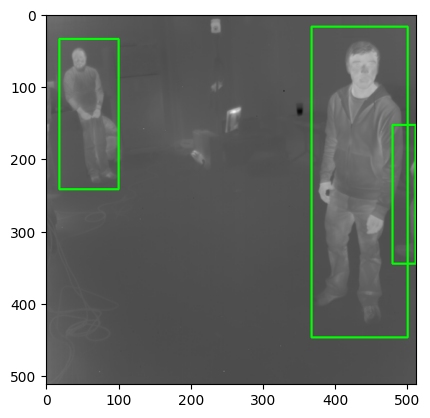

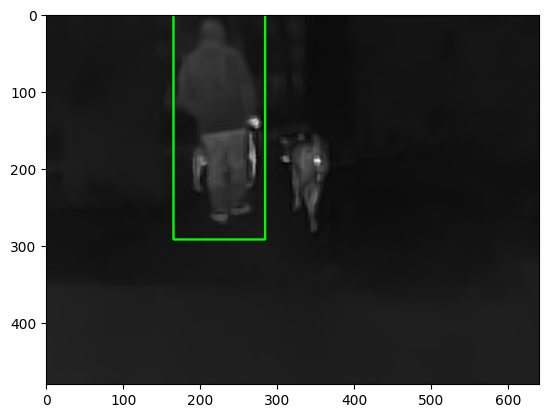

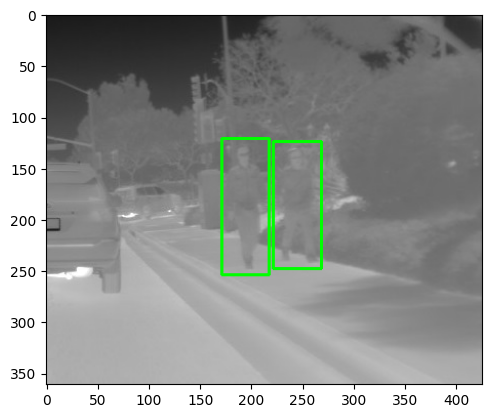

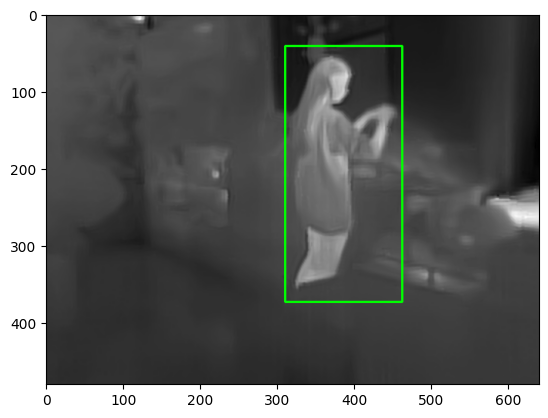

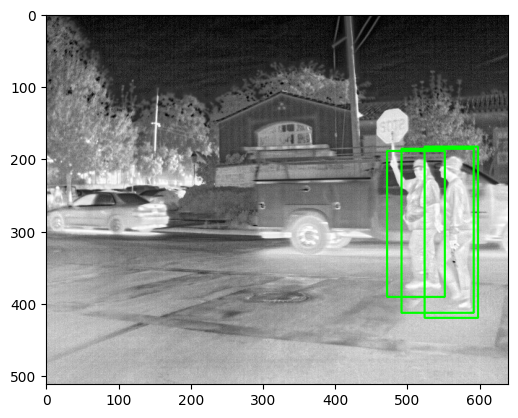

In [38]:
import cv2
import os
import matplotlib.pyplot as plt
import glob

thr_cutoff = 0.25
visualize_anns = True
n_max_show = 5
save_imgs = False


grouped_data = data.copy().sample(frac=1).groupby("file_name", sort= False)
files = glob.glob(f"data/thermal_pose/coco_fmt/dataset/{split}/*")
map_to_src = {file.split("/")[-1].split(".")[0]:file for file in files}
counter = 0
for filename, img_data in grouped_data:
    img_data = img_data[img_data["score"] >= thr_cutoff]
    img_src = map_to_src[filename]
    img = cv2.imread(img_src)
    for ann in img_data["bbox"]: 
        x1 = int(ann[0])
        y1 = int(ann[1])
        x2 = int(x1 + ann[2])
        y2 = int(y1 + ann[3])
        img = cv2.rectangle(img, (x1,y1),(x2,y2), color = (0,255,0),thickness = 2)
    if visualize_anns:
        plt.imshow(img)
        plt.show()
        counter += 1
        if counter == n_max_show:
            break
    if save_imgs:
        cv2.imwrite(f"output/{filename}.jpg", img)

    